```{try_on_binder}
```

In [1]:

from IPython import get_ipython
ip = get_ipython()
if ip is not None:
    ip.run_line_magic('load_ext', 'pymor.discretizers.builtin.gui.jupyter')
    ip.run_line_magic('matplotlib', 'inline')

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
import pymor.tools.random
pymor.tools.random._default_random_state = None



The pymor.discretizers.builtin.gui.jupyter extension is already loaded. To reload it, use:
  %reload_ext pymor.discretizers.builtin.gui.jupyter


# Tutorial: Linear time-invariant systems

In this tutorial,
we discuss finite-dimensional, continuous-time, linear time-invariant (LTI)
systems of the form

```{math}
\begin{align}
    E \dot{x}(t) & = A x(t) + B u(t), \\
    y(t) & = C x(t) + D u(t).
\end{align}
```

where
{math}`u` is the input,
{math}`x` the state, and
{math}`y` the output of the system,
and {math}`A, B, C, D, E` are matrices of appropriate dimensions
(more details can be found in {cite}`A05`).
In pyMOR, these models are captured by {{ LTIModels }},
which contain the matrices {math}`A, B, C, D, E` as {{ Operators }}.
We start by building an {{ LTIModel }} and then demonstrate some of its properties,
using a discretized heat equation as the example.

We focus on a non-parametric example,
but parametric LTI systems can be handled similarly
by constructing {math}`A, B, C, D, E` as parametric {{ Operators }} and
passing {{ parameter_values }} via the `mu` argument to the methods of the
{{ LTIModel }}.

## Building a model

We consider the following one-dimensional heat equation over {math}`(0, 1)` with
two inputs {math}`u_1, u_2` and three outputs {math}`y_1, y_2, y_2`:

```{math}
\begin{align}
    \partial_t T(\xi, t) & = \partial_{\xi \xi} T(\xi, t) + u_1(t),
    & 0 < \xi < 1,\ t > 0, \\
    -\partial_\xi T(0, t) & = -T(0, t) + u_2(t),
    & t > 0, \\
    \partial_\xi T(1, t) & = -T(1, t),
    & t > 0, \\
    y_1(t) & = T(0, t),
    & t > 0, \\
    y_2(t) & = T(0.5, t),
    & t > 0, \\
    y_3(t) & = T(1, t),
    & t > 0.
\end{align}
```

There are many ways of building an {{ LTIModel }}.
Here, we show how to build one from custom matrices,
instead of using a discretizer as in {doc}`tutorial_builtin_discretizer`
(and the {meth}`~pymor.models.basic.InstationaryModel.to_lti` method of
{{ InstationaryModel }} to obtain an {{ LTIModel }}).
In particular, we will use the
{meth}`~pymor.models.iosys.LTIModel.from_matrices` method of {{ LTIModel }},
which instantiates an {{ LTIModel }} from NumPy or SciPy matrices.

First, we do the necessary imports and some matplotlib style choices.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sps
from pymor.models.iosys import LTIModel

plt.rcParams['axes.grid'] = True

Next, we can assemble the matrices based on a centered finite difference
approximation using standard methods of NumPy and SciPy.

In [3]:

k = 50
n = 2 * k + 1

E = sps.eye(n, format='lil')
E[0, 0] = E[-1, -1] = 0.5
E = E.tocsc()

d0 = n * [-2 * (n - 1)**2]
d1 = (n - 1) * [(n - 1)**2]
A = sps.diags([d1, d0, d1], [-1, 0, 1], format='lil')
A[0, 0] = A[-1, -1] = -n * (n - 1)
A = A.tocsc()

B = np.zeros((n, 2))
B[:, 0] = 1
B[0, 0] = B[-1, 0] = 0.5
B[0, 1] = n - 1

C = np.zeros((3, n))
C[0, 0] = C[1, k] = C[2, -1] = 1


Then, we can create an {{ LTIModel }} from NumPy and SciPy matrices `A`, `B`, `C`,
`E`.

In [4]:
fom = LTIModel.from_matrices(A, B, C, E=E)

We can take a look at the internal representation of the {{ LTIModel }} `fom`.

In [5]:
fom

LTIModel(
    NumpyMatrixOperator(<101x101 sparse, 301 nnz>, source_id='STATE', range_id='STATE'),
    NumpyMatrixOperator(<101x2 dense>, range_id='STATE'),
    NumpyMatrixOperator(<3x101 dense>, source_id='STATE'),
    D=ZeroOperator(NumpyVectorSpace(3), NumpyVectorSpace(2)),
    E=NumpyMatrixOperator(<101x101 sparse, 101 nnz>, source_id='STATE', range_id='STATE'))

From this, we see that the matrices were wrapped in {{ NumpyMatrixOperators }},
while the default value was chosen for the {math}`D` matrix
({class}`~pymor.operators.constructions.ZeroOperator`).
The operators in an {{ LTIModel }} can be accessed via its attributes, e.g.,
`fom.A` is the {{ Operator }} representing the {math}`A` matrix.

We can also see some basic information from `fom`'s string representation

In [6]:
print(fom)

LTIModel
    class: LTIModel
    number of equations: 101
    number of inputs:    2
    number of outputs:   3
    continuous-time
    linear time-invariant
    solution_space:  NumpyVectorSpace(101, id='STATE')


which gives the dimensions of the underlying system more directly,
together with some of its properties.

## Transfer function evaluation

The transfer function {math}`H` is the function such that
{math}`Y(s) = H(s) U(s)`,
where {math}`U` and {math}`Y` are respectively the Laplace transforms of
the input {math}`u` and the output {math}`y`,
assuming zero initial condition ({math}`x(0) = 0`).
The expression for {math}`H` can be found by applying the Laplace transform
to the system equations to obtain

```{math}
\begin{align}
    s E X(s) & = A X(s) + B U(s), \\
    Y(s) & = C X(s) + D U(s).
\end{align}
```

using that {math}`s X(s)` is the Laplace transform of {math}`\dot{x}(t)`.
Eliminating {math}`X(s)` leads to

```{math}
Y(s) = \left( C (s E - A)^{-1} B + D \right) U(s),
```

i.e., {math}`H(s) = C (s E - A)^{-1} B + D`.
Note that {math}`H` is a matrix-valued rational function
(each component is a rational function).

The transfer function of a given {{ LTIModel }} is stored as the attribute
`transfer_function`.
It can be evaluated using its
{meth}`~pymor.models.transfer_function.TransferFunction.eval_tf` method.
The result is a NumPy array.

In [7]:
print(fom.transfer_function.eval_tf(0))
print(fom.transfer_function.eval_tf(1))
print(fom.transfer_function.eval_tf(1j))

[[0.5        0.66666667]
 [0.625      0.5       ]
 [0.5        0.33333333]]
[[0.31606222 0.4999973 ]
 [0.39347047 0.30326476]
 [0.31606222 0.18394049]]
[[0.37281526-0.21715839j 0.55742226-0.1956196j ]
 [0.46483929-0.27336178j 0.36331911-0.23241964j]
 [0.37281526-0.21715839j 0.22541935-0.17719566j]]


Similarly, the derivative of the transfer function can be computed using the
{meth}`~pymor.models.transfer_function.TransferFunction.eval_dtf` method.
The result is again a NumPy array.

In [8]:
print(fom.transfer_function.eval_dtf(0))
print(fom.transfer_function.eval_dtf(1))
print(fom.transfer_function.eval_dtf(1j))

[[-0.2916625  -0.25926111]
 [-0.36718437 -0.3125    ]
 [-0.2916625  -0.24073889]]
[[-0.11600655 -0.10808607]
 [-0.14598636 -0.12374206]
 [-0.11600655 -0.09196959]]
[[-0.10621989+0.18938184j -0.10083093+0.16301232j]
 [-0.13365757+0.23848281j -0.11317824+0.20350967j]
 [-0.10621989+0.18938184j -0.08260248+0.16036596j]]


To evaluate the transfer function over a sequence of points on the imaginary
axis,
the {meth}`~pymor.models.transfer_function.TransferFunction.freq_resp` method
can be used.
A typical use case is plotting the transfer function,
which is discussed in the next section.

## Magnitude and Bode plots

It is known that if the input is chosen as
{math}`u(t) = a e^{\xi t} \sin(\omega t + \varphi) e_j`
(where {math}`e_j` is the {math}`j`-th canonical vector),
then

```{math}
\lim_{t \to \infty}
\left(
  y_i(t)
  - a \lvert H_{ij}(\xi + \boldsymbol{\imath} \omega) \rvert e^{\xi t}
  \sin(\omega t + \varphi + \arg(H_{ij}(\xi + \boldsymbol{\imath} \omega)))
\right)
= 0.
```

In words, if the input is a pure exponential,
the frequency is preserved in the output,
the amplitude is multiplied by the amplitude of the transfer function, and
the phase is shifted by the argument of the transfer function.
In particular, if the input is sinusiodal, i.e., {math}`\xi = 0`,
then the output is also sinusiodal.

It is of interest to plot the transfer function over the imaginary axis to
visualize how the LTI system responds to each frequency in the input.
Since the transfer function is complex-valued (and matrix-valued),
there are multiple ways to plot it.

One way is the "magnitude plot", a visualization of the mapping
{math}`\omega \mapsto \lVert H(\boldsymbol{\imath} \omega) \rVert`,
using the {meth}`~pymor.models.transfer_function.TransferFunction.mag_plot`
method.

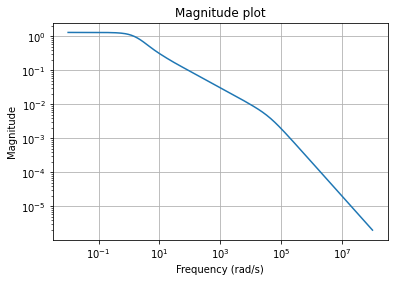

In [9]:
w = np.logspace(-2, 8, 300)
_ = fom.transfer_function.mag_plot(w)

Note that {meth}`~pymor.models.transfer_function.TransferFunction.mag_plot`
computes the Frobenius norm of {math}`H(\boldsymbol{\imath} \omega)` by default,
just as `scipy.linalg.norm`.
Likewise, the choice of the norm {math}`\lVert \cdot \rVert` can be controlled
using the `ord` parameter.

Another visualization is the Bode plot,
which shows the magnitude and phase of each component of the transfer function.
More specifically,
{math}`\omega \mapsto \lvert H_{ij}(\boldsymbol{\imath} \omega) \rvert`
is in subplot {math}`(2 i - 1, j)` and
{math}`\omega \mapsto \arg(H_{ij}(\boldsymbol{\imath} \omega))`
is in subplot {math}`(2 i, j)`.

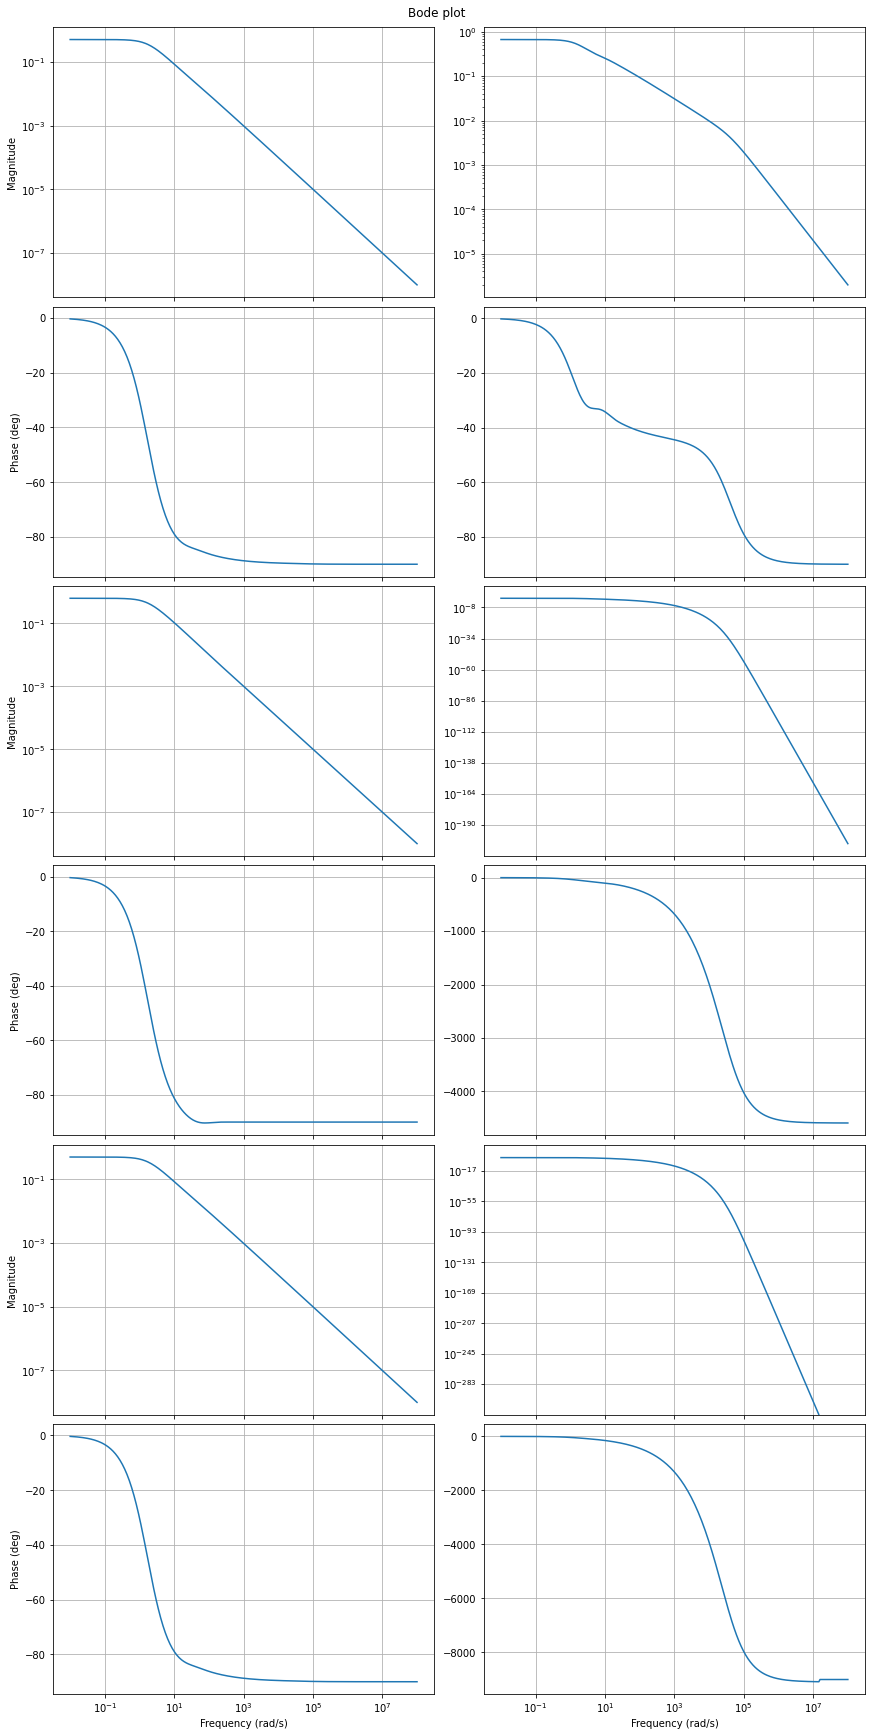

In [10]:
_ = fom.transfer_function.bode_plot(w)

## System poles

The poles of an LTI system are the poles of its transfer function.
From the form of the transfer function
it follows that the poles are eigenvalues of {math}`E^{-1} A`,
assuming that {math}`E` is invertible.
Conversely, the eigenvalues of {math}`E^{-1} A` are the poles of the system
in the generic case
(more precisely, if the system is minimal, i.e., controllable and observable;
see {cite}`A05`).

The poles of an {{ LTIModel }} can be obtained using its
{meth}`~pymor.models.iosys.LTIModel.poles` method
(assuming the system is minimal).

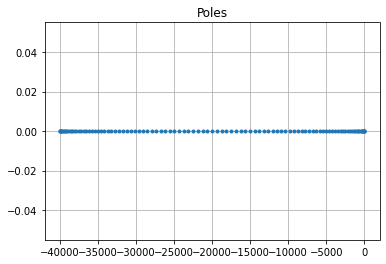

In [11]:
poles = fom.poles()
fig, ax = plt.subplots()
ax.plot(poles.real, poles.imag, '.')
_ = ax.set_title('Poles')

:::{note}

The {meth}`~pymor.models.iosys.LTIModel.poles` method uses a dense
eigenvalue solver,
which is applicable only up to medium-sized problems.

:::

## System Gramians

The controllability and observability Gramians of an asymptotically stable
system with invertible {math}`E` are respectively

```{math}
\begin{align*}
    P & =
    \int_0^\infty
    e^{t E^{-1} A} E^{-1} B
    B^{\operatorname{T}} E^{-\!\operatorname{T}}
    e^{t A^{\operatorname{T}} E^{-\!\operatorname{T}}}
    \operatorname{d}\!t, \text{ and} \\
    E^{\operatorname{T}} Q E & =
    \int_0^\infty
    e^{t A^{\operatorname{T}} E^{-\!\operatorname{T}}}
    C^{\operatorname{T}} C
    e^{t E^{-1} A}
    \operatorname{d}\!t.
\end{align*}
```

From this,
it is clear that {math}`P` and {math}`Q` are symmetric positive semidefinite.
Furthermore,
it can be shown that {math}`P` and {math}`Q` are solutions to Lyapunov equation

```{math}
\begin{align*}
    A P E^{\operatorname{T}}
    + E P A^{\operatorname{T}}
    + B B^{\operatorname{T}}
    & = 0, \\
    A^{\operatorname{T}} Q E
    + E^{\operatorname{T}} Q A
    + C^{\operatorname{T}} C
    & = 0.
\end{align*}
```

The Gramians can be used to quantify how much does the input influence the state
(controllability) and state the output (observability).
This is used to motivate the balanced truncation method
(see {doc}`tutorial_bt`).
Also, they can be used to compute the {math}`\mathcal{H}_2` norm (see below).

To find the "Gramians" {math}`P` and {math}`Q` of an {{ LTIModel }},
the {meth}`~pymor.models.iosys.LTIModel.gramian` method can be used.
Although solutions to Lyapunov equations are generally dense matrices,
they can be often be very well approximated by a low-rank matrix.
With {meth}`~pymor.models.iosys.LTIModel.gramian`,
it is possible to compute the dense solution or only the low-rank Cholesky
factor.
For example, the following computes the low-rank Cholesky factor of the
controllability Gramian as a {{ VectorArray }}:

In [12]:
fom.gramian('c_lrcf')

NumpyVectorArray(
    [[-9.67050759e-01 -9.49603788e-01 -9.37818152e-01 ... -5.08356138e-01
      -5.03442167e-01 -4.98481264e-01]
     [-1.13133419e+00 -9.59580542e-01 -8.43810516e-01 ...  1.94699113e-01
       1.92880555e-01  1.91000976e-01]
     [ 9.08538963e-01  4.58145972e-01  2.24375612e-01 ...  9.25753046e-02
       9.17614570e-02  9.08841977e-02]
     ...
     [-4.48720858e-17  1.95466800e-15 -3.87392910e-14 ... -1.84179333e-10
       3.10420349e-11 -2.87160762e-12]
     [ 3.97648476e-18 -1.92190365e-16  4.26024322e-15 ... -2.24465928e-11
       1.75879252e-12 -8.24288506e-14]
     [-1.85127015e-17  7.70480426e-16 -1.45373940e-14 ...  1.65200046e-10
      -3.71100064e-11  4.41382006e-12]],
    NumpyVectorSpace(101, id='STATE'))

## Hankel singular values

The Hankel singular values of an LTI system are
{math}`\sigma_i = \sqrt{\lambda_i(E^{\operatorname{T}} Q E P)}`,
where {math}`\lambda_i` is the {math}`i`-th eigenvalue.

Plotting the Hankel singular values shows us how well an LTI system can be
approximated by a reduced-order model.
The {meth}`~pymor.models.iosys.LTIModel.hsv` method can be used to compute them.

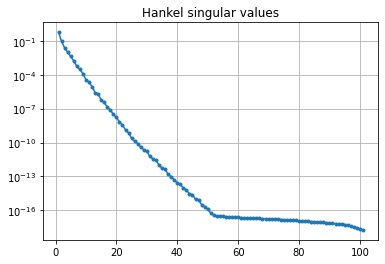

In [13]:
hsv = fom.hsv()
fig, ax = plt.subplots()
ax.semilogy(range(1, len(hsv) + 1), hsv, '.-')
_ = ax.set_title('Hankel singular values')

As expected for a heat equation, the Hankel singular values decay rapidly.

## System norms

There are various system norms,
used for quantifying the sensitivity of system's outputs to its inputs.
pyMOR currently has methods for computing:
the {math}`\mathcal{H}_2` norm,
the {math}`\mathcal{H}_\infty` norm, and
the Hankel (semi)norm.

The {math}`\mathcal{H}_2` norm is
(if {math}`E` is invertible,
{math}`E^{-1} A` has eigenvalues in the open left half plane, and
{math}`D` is zero)

```{math}
\lVert H \rVert_{\mathcal{H}_2}
=
\left(
  \frac{1}{2 \pi}
  \int_{-\infty}^{\infty}
  \lVert H(\boldsymbol{\imath} \omega) \rVert_{\operatorname{F}}^2
  \operatorname{d}\!\omega
\right)^{\frac{1}{2}}.
```

It can be shown that

```{math}
\lVert y \rVert_{\mathcal{L}_\infty}
\leqslant
\lVert H \rVert_{\mathcal{H}_2}
\lVert u \rVert_{\mathcal{L}_2}.
```

Additionally, for systems with a single input or a single output
(i.e., {math}`u(t) \in \mathbb{R}` or {math}`y(t) \in \mathbb{R}`),

```{math}
\lVert H \rVert_{\mathcal{H}_2}
=
\sup_{u \neq 0}
\frac{\lVert y \rVert_{\mathcal{L}_\infty}}{\lVert u \rVert_{\mathcal{L}_2}}.
```

The computation of the {math}`\mathcal{H}_2` norm is based on the system
Gramians

```{math}
\lVert H \rVert_{\mathcal{H}_2}^2
= \operatorname{tr}\!\left(C P C^{\operatorname{T}}\right)
= \operatorname{tr}\!\left(B^{\operatorname{T}} Q B\right).
```

The {meth}`~pymor.models.iosys.LTIModel.h2_norm` method of an {{ LTIModel }} can be
used to compute it.

In [14]:
fom.h2_norm()

2.0377751533822073

The {math}`\mathcal{H}_\infty` norm is
(if {math}`E` is invertible and
{math}`E^{-1} A` has eigenvalues in the open left half plane)

```{math}
\lVert H \rVert_{\mathcal{H}_\infty}
= \sup_{\omega \in \mathbb{R}}
\lVert H(\boldsymbol{\imath} \omega) \rVert_2.
```

It is always true that

```{math}
\lVert H \rVert_{\mathcal{H}_\infty}
=
\sup_{u \neq 0}
\frac{\lVert y \rVert_{\mathcal{L}_2}}{\lVert u \rVert_{\mathcal{L}_2}},
```

and, in particular,

```{math}
\lVert y \rVert_{\mathcal{L}_2}
\leqslant
\lVert H \rVert_{\mathcal{H}_\infty}
\lVert u \rVert_{\mathcal{L}_2}.
```

The {meth}`~pymor.models.iosys.LTIModel.hinf_norm` method uses a dense solver
from [Slycot](<https://github.com/python-control/Slycot>) to compute the
{math}`\mathcal{H}_\infty` norm.

In [15]:
fom.hinf_norm()

1.2890705455704852

The Hankel norm is
(if {math}`E` is invertible and
{math}`E^{-1} A` has eigenvalues in the open left half plane)

```{math}
\lVert H \rVert_{\operatorname{H}}
= \sigma_1,
```

i.e., the largest Hankel singular value.
Since it is independent of {math}`D`,
the "Hankel norm" is only a seminorm in general.

It can be shown that the Hankel norm is the norm of the Hankel operator
{math}`\mathcal{H} \colon \mathcal{L}_2(-\infty, 0) \to \mathcal{L}_2(0, \infty)`
mapping past inputs {math}`u_-` to future outputs {math}`y_+`

```{math}
y_+(t)
= \mathcal{H}(u_-)(t)
= \int_{-\infty}^0 h(t - \tau) u_-(\tau) \operatorname{d}\!\tau,
```

where {math}`h` is the impulse response
{math}`h(t) = C e^{t E^{-1} A} E^{-1} B + D \delta(t)`
(i.e., {math}`H` is the Laplace transform of {math}`h`).
Thus,

```{math}
\lVert H \rVert_{\operatorname{H}}
=
\sup_{u_- \neq 0}
\frac{\lVert y_+ \rVert_{\mathcal{L}_2}}{\lVert u_- \rVert_{\mathcal{L}_2}},
```

The computation of the Hankel norm in
{meth}`~pymor.models.iosys.LTIModel.hankel_norm` relies on the
{meth}`~pymor.models.iosys.LTIModel.hsv` method.

In [16]:
fom.hankel_norm()

0.6221361786735345

Download the code:
{download}`tutorial_lti_systems.md`,
{nb-download}`tutorial_lti_systems.ipynb`.